In [ ]:
# Importing useful things
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.circuit.library import HartreeFock
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit import Aer
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.algorithms import VQE
from IPython.display import display, clear_output
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
import numpy as np

# 1. Initializing the atomic structure of LiH using PySCF driver

First we initialize the LiH molecule (this code was already provided in the exercise) in the most stable configuration of inter-atomic distance i.e. at 1.5474Å between the Li and H atoms.

In [2]:
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

Then we initialize the backend as the `statevector_simulator` for running the VQE problem

In [3]:
backend = Aer.get_backend('statevector_simulator')

We derive the useful information like number of electrons (`n_el`), number of molecular orbitals (`n_mo`), number of spin orbitals (`n_so`), number of qubits (`n_q`, which is actually equal to `n_so`), and the nuclear repulsion energy of the molecule (`e_nn`).

In [4]:
n_el = qmolecule.num_alpha + qmolecule.num_beta
n_mo = qmolecule.num_molecular_orbitals
n_so = 2 * qmolecule.num_molecular_orbitals
n_q = 2 * qmolecule.num_molecular_orbitals
e_nn = qmolecule.nuclear_repulsion_energy

# 2. Defining the problem

The electronic structure of Hydrogen ($H$) is $[1s^1]$, and for Lithium ($Li$) it is $[1s^2 2s^1]$.

From the above electronic structures, we can see that only the 1st and 2nd molecular orbitals participate in the chemical reaction between $H$ and $Li$ to for $LiH$. The LiH molecule has the following electronic structure:-

$$
LiH = 1s^2 2s^2
\tag{2.1}
$$

The above configuration of the LiH molecule is a stable configuration as it has all the molecular orbitals fully filled, essentially giving it noble-gas-like reactivity properties. The electronegativity of the overall molecule decreases and hence the energy of the reaction also falls down when compared to the inital total energy of the reactants.

Therefore, from the above analysis, we can see that we only need to consider the molecular orbitals number 1 and 2 for this experiment. The other empty orbitals can be removed as they don't play a role the reaction. For the removal process I have used the `FreezeCoreTransformer` from `qiskit_nature.transformers` to remove the orbitals \[3, 4\] as shown below. This gives us a good approximation of the energy value and also doesn't overutilize the resources (in this case, qubits) of the quantum system on which the experiment is being run.

In [ ]:
qmolecule_transformers = [FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3, 4])]

After applying the `FreezeCoreTransformer`, we have successfully reduced our problem into only calculating the energy for the useful parts of our chemical reaction.

Now I use this instance of the `FreezeCoreTransformer` to derive an electronic structure problem using the `ElectronicStructureProblem` class in the `qiskit_nature.problems.second_quantization.electronic` package.

This gives us access to the second quantized operators of the problem Hamiltonian in terms of the creation ($a^ \dagger$) and annihilation ($a$) fermionic operators. This converts the problem into description of a fermionic system having $N$ single partical states (representing a spin orbital each) which can either be empty or occupied. With this process we can convert the k-local hamiltonian into a 2-local representation. The general representation of the 2-local Hamiltonian looks like:-

$$
H = \sum _{i,j} h_{ij} a^\dagger _i a_j \ + \ \frac{1}{2} \sum _{i,j,k,l} h_{ijkl} a^\dagger_i a^\dagger_j a_k a_l
\tag{2.2}
$$

Once we map the spin orbital electronic structure to qubits, we can easily perform a tensor product of the quantum states to derive the full quantum wavefunction of the molecule. Using this wavefunction then, we can perform quantum operations to find the grund-state energy eigenvalue of the LiH molecule. The above hamiltonian is stored in the variable `main_op`.

In [15]:
# Define the problem
problem = ElectronicStructureProblem(driver, q_molecule_transformers=qmolecule_transformers)
second_q_ops = problem.second_q_ops() # Generate the second-quantized operators
main_op = second_q_ops[0] # Hamiltonian

print('Number of molecular orbitals: ', problem.molecule_data_transformed.num_molecular_orbitals)
print('Number of spin orbitals: ', 2 * problem.molecule_data_transformed.num_molecular_orbitals)

Number of molecular orbitals:  3
Number of spin orbitals:  6


# 3. Mapping Fermions to Qubits

Once we get the problem hamiltonian, we now have to map the fermionic operators onto the qubits so that e can encode the chemical information of the $LiH$ molecule onto our quantum computer.

Since, we have 3 molecular orbitals (and 6 spin orbitals) associated to our $LiH$ simulation problem, we will have to use atleast 6-qubits to successfully map the fermionic operators to qubits using Jordan-Wigner or Bravyi-Kitaev mapping. However, if we use Parity mapping, it can reduce the number of qubits to just 5-qubits through qubit tapering of fermionic spin-parity symmetries. For this, I use the `ParityMapping` function from the `qiskit_nature.mappers.second_quantization` package.

We can further optimize our resource usage by finding $\mathbb{Z}_2$ -symmetries in the system as we only work with the s-orbital here and hence we get one $\mathbb{Z}_2$ -symmetry. This reduces one more qubit from our bag of qubit resource and finally we end up with having just 4-qubits for our $LiH$ molecule simulation which is the most optimal number of qubits that we can get.

In [ ]:
# Qubit Converter
mapper = ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction='auto')
print(converter.z2symmetries)

Then, we finally generate our qubit operators which are derived from the fermionic operators after this whole conversion procedure. The variable `qubit_op` stores the qubit operators as an array of spare pauli operations applied to initialise the qubits into the proper state corresponding to the quantum wavefunction of the $LiH$ molecule.

In [6]:
# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles, sector_locator=problem.symmetry_sector_locator)
qubit_op

Z2 symmetries:
Symmetries:
Single-Qubit Pauli X:
Cliffords:
Qubit index:
[]
Tapering values:
  - Possible values: []


TaperedPauliSumOp(SparsePauliOp([[False, False, False, False, False, False, False, False],
               [False, False, False, False, False, False, False,  True],
               [False, False, False, False, False, False,  True, False],
               [False, False, False, False, False, False,  True,  True],
               [False, False, False, False, False,  True, False, False],
               [False, False, False, False, False,  True, False,  True],
               [False, False, False, False, False,  True,  True, False],
               [False, False, False, False, False,  True,  True,  True],
               [False, False, False, False,  True, False, False, False],
               [False, False, False, False,  True, False, False,  True],
               [False, False, False, False,  True, False,  True, False],
               [False, False, False, False,  True, False,  True,  True],
               [False, False, False, False,  True,  True, False, False],
               [False, False, Fal

Now using the electronic structure problem hamiltonian and the qubit operator, we can diagonalize the actual hamiltonian to get the exactly calculated ground-state energy eigenvalue for the $LiH$ molecule ans store it in the variable `exact_energy` for future reference.

In [8]:
def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)

Exact electronic energy -1.0887060157347357


# 4. Generating the initial state

For generating the initial state, we resort to the Hartree-Fock perturbation theory in order to approximate the qubit operator `qubit_op` as a string of Pauli gates that can be applied to initialize the state of the system.

We can achieve this by using the `HartreeFock` class found in the `qiskit_nature.circuit.library` package like so,

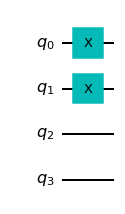

In [7]:
# HartreeFock Initial state
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
init_state.draw('mpl')

# 5. Developing the Problem Ansatz

**Ansatz** is referred an educated guess or an assumption for solving a particular problem. It proivdes us with an initial estimate of the solution framework of any mathematical problem. We use an ansatz in this as we can never be exactly sure about the transformations that one needs to apply on the initial Hartree-Fock state for a molecular simulation problem to get the ground-state energy eigenvalue. Hence, we make an initial assumption and then keep changing the parameters/variables in the ansatz to optimize our final result.

After the initial state is generated and stored in the variable `init_state`, we work on developing the Ansatz for the problem.

One point we can straightaway notice is that our Hamiltonian in $eq. 2.2$ is a 2-local hamiltonian. Hence, the ansatz that we need will likely be such that it will have some single-qubit parameterized rotations and every adjacent qubit in the circuit will be entangled so as to simulate the effect of near-range interactions between the fermions of the $LiH$ molecule. Hence, we can fulfill these constrainsts of the ansatz by using the `TwoLocal` variational form from the `qiskit.circuit.library` package. Therefore, the code for the same will look like so,

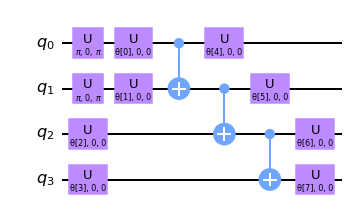

In [9]:
# Ansatz Generation Parameters
rotation_blocks = ['ry']
entanglement_blocks = 'cx'
entanglement = 'linear'
repetitions = 1
skip_final_rotation_layer = False

# Instantiating the TwoLocal variational form as the problem ansatz
ansatz_temp = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                      entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)

# Prepending the initial state to the ansatz
ansatz_temp.compose(init_state, front=True, inplace=True)

# Transpiling the ansatz to have only 'u' and 'cx' gates
from qiskit import transpile
ansatz_t = transpile(ansatz_temp, basis_gates=['u', 'cx'], optimization_level=3)
ansatz_t.draw('mpl')

Finally, we run our VQE algorithm on the above circuit to iteratively optimize the circuit parameters and find the ground-state energy eigenvaluue for the $LiH$ molecule problem like so,

In [10]:
# Print the progress of optimization process
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)

# Set initial parameters of the ansatz
try:
    initial_point = [0.01] * len(ansatz_t.ordered_parameters)
except:
    initial_point = [0.01] * ansatz_t.num_parameters


# Define the optimizer to use
optimizer = SLSQP(maxiter=3000, tol=0.0001)

# Initialize the VQE problem
algorithm = VQE(ansatz_t,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

# Compute minimum energy eigenvalue of the ansatz
result = algorithm.compute_minimum_eigenvalue(qubit_op)
    
print('Optimal VQE Energy: ', result.optimal_value)
print(result)
print('Completed!')

-1.0863669627124737
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 382,
    'eigenstate': array([ 1.44328477e-03-1.60579700e-19j, -4.96356008e-03-4.24249959e-21j,
        2.65620193e-02-4.52278690e-20j, -9.91390889e-01-1.19491577e-21j,
       -5.41567628e-02+6.62855170e-18j, -2.74420486e-04+1.75125672e-19j,
        9.17478065e-04-3.43312227e-20j, -2.41085956e-02-9.07027465e-22j,
       -2.75862397e-03+3.37618296e-19j, -6.16754924e-06+8.91984154e-21j,
        4.95851927e-06-1.67625051e-21j,  3.30760491e-04-4.42863706e-23j,
        1.13527959e-01-1.38945094e-17j,  3.22266316e-04-3.67091545e-19j,
       -5.70152849e-04+6.96195170e-20j,  4.80524570e-05+1.83934066e-21j]),
    'eigenvalue': -1.0863669627124737,
    'optimal_parameters': {   ParameterVectorElement(θ[6]): 3.1901804844152615,
                              ParameterVectorElement(θ[0]): 0.25224802487276127,
                              ParameterVectorElement(θ[2]): -3.1416856484938513,
                         

Once we get the optimal value from our VQE result, we check if the solution is within the error margin of $4 mHa$ and also count the number of CNOT gates which is the cost for this problem.

In [11]:
# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz_t)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'mapping': converter.mapper.__class__.__name__,
    'ansatz': ansatz_t.__class__.__name__,
    'energy (Ha)': energy,
    'error (mHa)': (energy - exact_energy)*1000,
    'pass': (energy - exact_energy)*1000 <= accuracy_threshold,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    'score': score
}

print('Ansatz used: ', result_dict['ansatz'])
print('Number of parameters: ', result_dict['# of parameters'])
print('VQE Energy: ', result_dict['energy (Ha)'])
print('Error: ', result_dict['error (mHa)'])
print('Pass/Fail: ', result_dict['pass'])
print('CNOT score: ', result_dict['score'])

Ansatz used:  QuantumCircuit
Number of parameters:  8
VQE Energy:  -1.0863669627124737
Error:  2.3390530222620054
Pass/Fail:  True
CNOT score:  3


In [12]:
# Check your answer using following code
from qc_grader import grade_ex5
freeze_core = True # change to True if you freezed core electrons
grade_ex5(ansatz_temp,qubit_op,result,freeze_core)

Grading your answer for ex5. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.
Feel free to submit your answer.

